# Programming Exercise 3: Multi-class Classification and Neural Networks

## Introduction

```
by Seokkyu Kong
Date: 2016-03-19
Summary: Coursera machine learning (Prof. Andrew Ng) 강의 내용과 assignment는 octave(matlab)으로 이루어진다. 
해당 코드를 python으로 구현해본다.

Andrew Ng 교수의 강의: https://www.coursera.org/learn/machine-learning/
```

Numpy 와 MATLAB 참고 자료

- [Numpy for Matlab users #1](https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html)
- [NumPy for MATLAB users #2](http://mathesaurus.sourceforge.net/matlab-numpy.html)

이 연습문제에서는 one-vs-all logistic regression을 구현하고 필기체 숫자를 인식하기 위한 뉴럴 네트워크를 구현할 것이다. 

아래는 구현 대상 프로그램이다.

* lrCostFunction.m - Logistic regression cost function
* oneVsAll.m - Train a one-vs-all multi-class classifier
* predictOneVsAll.m - Predict using a one-vs-all multi-class classifier 
* predict.m - Neural network prediction function

## 1. Multi-class Classification

자동으로 필기체 숫자를 인식하는 것은 오늘날 널리 사용되고 있다. 이 연습문제에서는 이와 같은 분류 작업을 하기 위해 사용될 수 있는 방법들을 배운다.

연습문제 첫번째 파트에서는 이전의 logistic regression 구현을 확장해서 one-vs-all classification에 적용할 것이다.

### 1.1 Dataset

ex3data1.mat 파일은 필기체 숫자 5000개의 training examples를 포함하고 있다. mat 포맷은 Octave/MATLAB 포맷으로 저장되었음을 나타낸다. 이들 행렬은 load 명령어를 이용해서 직접 읽을 수 있다. matrix는 이미 이름을 가지고 있기 때문에 따로 이름을 지정할 필요는 없다. 

ex3data1.mat은 5000개의 training examples가 있는데, 각각의 example은 20 x 20 pixel로 된 grayscale 숫자 이미지이다. 각각의 픽셀은 해당 위치에서 grayscale (밝기)강도를 나타내는 float 실수로 표현된다. 20 x 20 픽셀은 400 dimension vector로 펼쳐진다. 이들 training example 각각은 행렬 X 내에 하나의 row가 된다. 이것은 5000 x 400 행렬이 된다. 

training set의 두번째 부분은 labels를 포함하는 5000 dimension vector인 y가 된다. Octave/MATLAB 인덱싱과 호환성을 유지하기 위해서 0 인덱스는 없고, 숫자 0은 10에 매핑된다. 따라서 숫자 "0"은 "10"으로 label되고 숫자 "1" 에서 "9"는 "1"에서 "9"로 라벨링된다.

### 1.2 Visualizing the data

행렬 X에서 임의로 100개의 row를 추출해서 displayData() 함수에 전달할 것이다. 이 함수는 각각의 행을 20x20 grayscale 이미지로 매핑시키고 해당 이미지를 보여줄 것이다. 우리는 displayData()함수를 제공하지만 코드가 어떻게 동작하는지 직접 볼 것을 권장한다. 

이 단계 실행 후 아래와 같은 이미지를 볼 수 있을 것이다.



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio # MATLAB 파일을 읽는다.

In [3]:
input_layer_size = 400 # 20x20 Input Images of Digits
num_labels = 10 # 10 lables, from 1 to 10 ("0"을 label 10으로 매핑함)

## Part 1: Loading and Visualizing Data

# Load Training Data
mat_contents = sio.loadmat('ex3data1.mat')

X = mat_contents['X']
y = mat_contents['y']

y = np.array(y[0:,0])
print(y.shape)
print(y[:10])

(5000,)
[10 10 10 10 10 10 10 10 10 10]


In [4]:
m = X.shape[0]

# Randomly select 100 data points to display
# Octave의 randperm(n) 함수 대신 random.shuffle(x) 을 사용할 수 있다.
# ****************************************************************
# XXX: random.shuffle()은 객체의 내용 자체를 랜덤하게 섞는다.
# rand_indices: 0~4999
# ****************************************************************
rand_indices = np.arange(m)
random.shuffle(rand_indices)

sel = X[rand_indices[0:100,], :]
print(sel.shape) # 100x400

(100, 400)


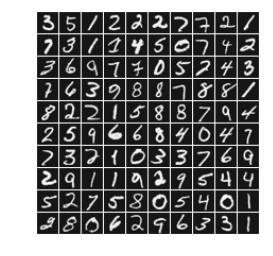

In [11]:
def displayData(X, example_width = 0):
    """
    2D 데이터를 그리드 형식에 표시한다. 
    그림에 대한 핸들 h와 요청된 배열을 반환한다.
    """
    # example_width를 설정한다.
    if example_width == 0:
        example_width = round(np.sqrt(X.shape[1]))
    
    # rows, cols 수를 계산한다.
    
    m, n = X.shape
    example_height = (n / example_width)
    #m = 100, n = 400
    #print('m = %s, n = %s' % (m, n))
    
    example_width = int(example_width)
    example_height = int(example_height)
    #width = 20, height = 20
    #print('width = %s, height = %s' % (example_width, example_height))
    
    # 그려질 item의 갯수를 계산한다.
    display_rows = floor(np.sqrt(m))
    display_cols = ceil(m / display_rows)
    #rows = 10.0, cols = 10.0
    #print('rows = %s, cols = %s' % (display_rows, display_cols))  
    
    # 이미지 사이의 패딩을 설정한다.
    pad = 1
    
    # 비어있는 디스플레이를 설정한다. (211, 211)
    display_array = np.ones((pad + display_rows * (example_height + pad), 
                           pad + display_cols * (example_width + pad)))
    
    # 1 + 100 * (20 + 1)
    #print(display_array.shape)
    
    # 각각의 example을 display array상으로 복사한다.
    # ***************************************************************************
    # XXX: np.arange가 정수를 반환하도록 index 부분은 dtype=int를 주도록 한다.
    # ***************************************************************************
    curr_ex = 0
    for j in np.arange(display_rows, dtype=int):
        for i in np.arange(display_cols, dtype=int):
            if curr_ex >= m:
                break;
                
            # Copy the patch
            
            # Get the max value of the patch
            max_val = np.max(np.abs(X[curr_ex, :]))

            # python에서 인덱스는 0부터 시작한다. (j - 1) => j, (i - 1) => i
            #x = pad + j * (example_height + pad) + np.arange(example_height, dtype=int)
            #y = pad + i * (example_width + pad) + np.arange(example_width, dtype=int)

            x = pad + j * (example_height + pad)
            y = pad + i * (example_width + pad)
            
            #print('x = %s, y = %s' % (x, y))
            #print(display_array[x: x + example_height, y:y + example_width].shape)
            
            # 이미지를 올바르게 보이기 위해서 reshape 후에 transpose 시킨다.
            display_array[x:x + example_height, y: y + example_width] = \
                X[curr_ex, :].reshape((example_height, example_width)).T / max_val;

            curr_ex = curr_ex + 1
            
            if curr_ex >= m:
                break

    # x, y축의 범위를 -1~1로 설정한다.
    im = imshow(display_array, interpolation = 'bilinear', 
                origin = 'upper', 
                extent=(-1,1,-1,1))
    plt.set_cmap('gray')
    # Do not show axis
    plt.axis('off')
    #show()
    
displayData(sel)


### 1.3 Verctorizing Logistic Resgression

multi-class classifier를 구축하기 위해서 다중 one-vs-all logistic regression model들을 사용해야 한다. 10개의 클래스가 있기 때문에 10개의 분리된 logistic regression classifier를 훈련시킬 필요가 있다. 이 트레이닝을 효율적으로 만들기 위해서 코드가 벡터화되는 것이 중요하다. 이번 섹션에서는 어떤 for loop 도 사용하지 않는 logistic regression의 벡터화 버전을 구현하게 될것이다. 이번 연습문제를 위해서 마지막 연습문제의 코드를 사용할 수 있다.

#### 1.3.1 Vectorizing the cost function

cost 함수의 벡터화 버전을 작성하는 것으로 시작한다. 

lrCostFunction.m 에서 unregularized cost 함수를 작성한다. cost 함수의 나머지 부분들도 벡터화된 접근법을 사용해야 한다. lrCostFunction.m의 완전한 벡터화 버전은 어떤 loop도 포함하지 않는다. 

(힌트: 요소곱 연산과 sum 연산을 사용할 수 있다)

#### 1.3.2 Vectorizing the gradient

Debugging Tip: 벡터화 코드는 때로는 교묘할 수 있다. 디버깅하기 위한 한가지 공통 전략은 행렬의 사이즈를 출력하는 것이다. 예를 들어 주어진 행렬 X가 100x20 크기(100개의 example, 20개의 feature) 그리고 theta(20x1 dimension)이 있을 때, X*theta는 올바른 연산이지만, theta*X는 그렇지 않다. 더우기, 만약 비벡터화된 코드를 가지고 있다면 벡터화된 코드의 출력값과 비교해서 같은 출력값인지 확인해볼 수 있다. 

lrCostFunction 에서는 어떤 loop도 있으면 안된다. 

Octave/MATLAB Tip: A(:, 3:5) = B(:, 1:3)을 하면 A의 컬럼 3~5를 B의 컬럼 1~3으로 대치한다. (물론, python에서는 B의 1~2를 A의 3~4로 대치한다.) 인덱싱에서 사용할 수 있는 한가지 특별한 키워드는 end 이다. 예를 들어 A(:, 2:end) 하면 A의 2번째에서 마지막 컬럼까지 반환한다. (물론, python 에서는 A[:, 1:] 라고 쓰면 된다.)

In [59]:
def sigmoid(z):
    """
    큰 양의 값에 대해서는 결과값이 1에 가깝고, 
    큰 음수의 값에 대해서는 0에 가깝다.
    simoid(0) = 0.5
    """
    g = 1 / (1  + np.exp(-z))
    
    return g

print('sigmoid(10) = %s, sigmoid(-10) = %s, sigmoid(0) = %s' 
      % (sigmoid(10), sigmoid(-10), sigmoid(0)))

sigmoid(10) = 0.999954602131, sigmoid(-10) = 4.53978687024e-05, sigmoid(0) = 0.5


In [60]:
def lrCostFunction(theta, X, y, s_lambda):
    """
    regularization을 가진 logistic regression 의 cost와 gradient를 계산한다.
    """
    
    """
    cost는 J 값으로 설정한다. 편미분을 계산하고 결과를 grad에 설정한다.
    
    힌트: cost 함수와 gradient 계산은 효율적으로 벡터화될 수 있다. 예를 들어 다음
    계산을 생각해보자. 
    
    sigmoid(X * theta)
    
    결과 행렬의 각 row는 해당 example의 예측값이 된다. 
    
    힌트: regularized cost 함수의 gradient를 계산할 때, 많은 벡터화 솔루션이 있지만
    한가지 가능한 방법은 아래와 같다
    
    grad = = (unregularized gradient for logistic regression)
    temp = theta; 
    temp(1) = 0;   % because we don't add anything for j = 0  
    grad = grad + YOUR_CODE_HERE (using the temp variable)
 
    """

    m, n = X.shape
    #m = np.size(y) # training examples 갯수
    
    # 아래 값을 올바르게 반환해야 한다.
    J = 0
    grad = np.zeros(np.size(theta))
    
    
    # sum_theta_square는 theta[0]를 포함하지 않는다. 
    sum_theta_square = np.sum(theta[1:] ** 2)
    
    # 예측값을 계산한다.
    X_theta = X.dot(theta)
    prediction = sigmoid(X_theta)

    # cost J를 계산한다.
    J = 1/m * np.sum(-y * log(prediction) - (1 - y) * log(1 - prediction)) \
        + s_lambda / (2 * m) * sum_theta_square
        
    # 편미분을 계산한다.
    error = prediction - y
    delta = 1/m * error.T.dot(X)
    
    temp = theta
    temp[0] = 0
    regular = (s_lambda / m) * temp
    
    grad = delta + regular
    
    return J, grad
          
def myCost(theta, X, y, s_lambda):

    # cost, gradient 계산을 별도로 하기 귀찮을때... -_-;
    #J, grad = lrCostFunction(theta, X, y, s_lambda)
    #return J

    m, n = X.shape
    #m = np.size(y) # training examples 갯수
    
    # 아래 값을 올바르게 반환해야 한다.
    J = 0
    grad = np.zeros(np.size(theta))
    
    
    # sum_theta_square는 theta[0]를 포함하지 않는다. 
    sum_theta_square = np.sum(theta[1:] ** 2)
    
    # 예측값을 계산한다.
    X_theta = X.dot(theta)
    prediction = sigmoid(X_theta)

    # cost J를 계산한다.
    J = 1/m * np.sum(-y * log(prediction) - (1 - y) * log(1 - prediction)) \
        + s_lambda / (2 * m) * sum_theta_square    
    
    return J
    
def myGradient(theta, X, y, s_lambda):

    # cost, gradient 계산을 별도로 하기 귀찮을때... -_-;
    #J, grad = lrCostFunction(theta, X, y, s_lambda)
    #return grad.flatten()
    
    
    m, n = X.shape
    #m = np.size(y) # training examples 갯수
    
    # 아래 값을 올바르게 반환해야 한다.
    grad = np.zeros(np.size(theta))
    
    # 예측값을 계산한다.
    X_theta = X.dot(theta)
    prediction = sigmoid(X_theta)

    # 편미분을 계산한다.
    error = prediction - y
    delta = 1/m * error.T.dot(X)
    
    temp = theta
    temp[0] = 0
    regular = (s_lambda / m) * temp
    
    grad = delta + regular    

    return grad.flatten()

    

# TEST CASE
theta1 = np.array([-2, -1, 1, 2]);
#X1 = [ones(3,1) magic(3)];
X1 = np.array([[1, 8, 1, 6],
    [1, 3, 5, 7],
    [1, 4, 9, 2]])
y1 = np.array([1, 0, 1])       # creates a logical array
y2 = (y1 >= 0.5)
# *****************************************************************************
# XXX: np.array 끼리 비교 시 True/False 를 1/0 으로 매핑하기: x.astype(int)
# *****************************************************************************
print(y2.astype(int))
s_lambda1 = 3
J, grad = lrCostFunction(theta1, X1, y2.astype(int), s_lambda1)
#J, grad = lrCostFunction(theta1, X1, y1, s_lambda1)
print(J, grad)

"""
% output:
J = 7.6832
grad =
   0.31722
   -0.12768
   2.64812
   4.23787
"""
print()

[1 0 1]
7.68316654981 [ 0.31722075 -0.12768456  2.6481235   4.23787228]



## 1.4 One-vs-all Classification

여기에서는 multiple regularized logistic regression classifier를 트레이닝 해서 K class 각각에 대한 one-vs-all 분류를 구현하게 될것이다. 필기체 숫자 이미지의 K=10 이지만, 코드는 어떤 K에 대해서도 동작해야 한다.

oneVsAll.m을 작성하는데, 이것은 각각의 클래스에 대해서 하나의 classifier를 훈련시킨다. 각각의 classifier를 독립적으로 훈련시키기 위해서 1에서 K까지 for-loop를 작성할 수 있다.

이 함수에 대한 y 인자는 1에서 10까지의 라벨로 구성된 벡터이며 숫자 "0"은 라벨 10에 매핑되었다. 

class k에 대해서 분류기를 훈련시킬 때, y는 m dimensional 벡터가 되는데, j번째가 1이면 해당 클래스 k에 속하고 0이면 해당 클래스가 아님을 나타낸다.

여기서는 fmincfg(fminunc 대신에)를 사용하는데, fminunc와 유사하게 동작하지만, 많은 수의 파라미터를 다루는데 더욱 효율적이다.

## Part 2: Vectorize Logistic Regression

In [61]:

## Part 2: Vectorize Logistic Regression

import scipy.optimize as op

def oneVsAll(X, y, num_labels, s_lambda):

    m, n = X.shape
    
    # 다음 변수값을 올바르게 반환해야 한다.
    all_theta = np.zeros((num_labels, n + 1))
    
    # 1을 X 행렬에 컬럼벡터로 추가한다.
    X = hstack((np.ones((m, 1)), X))
    
    # c: 0~9
    for c in np.arange(num_labels):
        c = c + 1 # 1부터 시작한다.
        initial_theta = np.zeros(n + 1)
        
        # 각 class 에 대한 분류기의 theta 정보는 row 형태로 저장된다.
        
        # *****************************************************************************
        # XXX: octave 에서는 (y == c) 의 결과는 1 0 0 1 등의 숫자로 나타난다.
        # python에서도 비슷하게 만드려면 y2 = (y == c); y2.astype(int) 를 해주고
        # array 타입으로 전달한다. (y == c) 는 [True False False True]의 결과이다.
        # *****************************************************************************
        y2 = (y == c)

        # 방식1: (50회, 5.39 sec), (100회, 11.5 sec)
        #theta = op.fmin_cg(myCost, fprime=myGradient,
        #    x0=initial_theta, args=(X, y2.astype(int), s_lambda), maxiter=50)
        
        #all_theta[c - 1, :] = theta
        
        # 방식2: 5.41 sec 
        Result = op.minimize(fun = myCost, x0 = initial_theta, args = (X, y2.astype(int), s_lambda), \
                     method = 'CG', jac = myGradient, options = {'maxiter': 50});
        all_theta[c - 1, :] = Result.x
        
        # cost 를 출력한다.
        #print(Result.fun)
        
    return all_theta


s_lambda = 0.1
%time all_theta = oneVsAll(X, y, num_labels, s_lambda) # 5.51 sec

all_theta[0, 0:5]

Wall time: 5.38 s


array([ -2.45142072e+00,   0.00000000e+00,   0.00000000e+00,
         3.29691340e-05,  -3.03980824e-04])

In [62]:
"""
In Octave:

Training One-vs-All Logistic Regression...
Iteration    50 | Cost: 1.401075e-02
Iteration    50 | Cost: 5.725277e-02
Iteration    50 | Cost: 6.364179e-02
Iteration    50 | Cost: 3.839547e-02
Iteration    50 | Cost: 6.139444e-02
Iteration    50 | Cost: 2.173256e-02
Iteration    50 | Cost: 3.636608e-02
Iteration    50 | Cost: 8.440462e-02
Iteration    50 | Cost: 7.934182e-02
Iteration    50 | Cost: 9.872806e-03
Program paused. Press enter to continue.

  -3.14365   0.00000   0.00000   0.00008  -0.00072
  
"""
print()

### 1.4.1 One-vs-all Prediction

one-vs-all 분류기를 훈련시킨 이후에는 주어진 이미지에 포함된 숫자를 예측하기 위해 분류기를 사용할 수 있다. 각각의 입력에 대해서 이미지가 각 클래스에 포함될 확률을 계산한다. 

one-vs-all 예측 함수는 가장 높은 확률을 가진 클래스를 골라서 class label (1, 2, ... K) 형식으로 반환한다.

predictOneVsAll.m 코드를 완성해야 한다. 일단, 마무리 되면, ex3.m 은 학습된 파라미터를 가지고 predictOneVsAll 함수를 호출할 것이다. training set 정확도는 약 94.9% 이다. (즉, 분류기는 트레이닝 셋의 94.9% 를 올바르게 분류한다.)

## Part 3: Predict for one-vs-All

In [63]:
# Part 3: Predict for one-vs-All

def predictOneVsAll(all_theta, X):
    """
    훈련된 one-vs-all 분류기를 이용해서 label을 예측한다. labels은 1..K 범위이다.
    여기서 K = size(all_theta, 1) 이다. 
    p = predctonevsall(all_theta, X)는 행렬 X내에 있는 각각의 example에 대해서 
    예측 벡터를 반환할 것이다. X는 example을 row 형식으로 포함하고 있다. 
    all_theta는 행렬인데 i번째 row는 i번째 클래스에 대한 훈련된 logistic regression theta 
    벡터가 된다.
    
    p 는 1..K 사이의 값으로 된 벡터로 설정해야 한다.
    """
    
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    
    # 다음 변수를 올바르게 반환할 필요가 있다.
    p = np.zeros(m)

    # 1을 행렬 X에 추가한다.
    X = hstack((np.ones((m, 1)), X))
    
    """
    아래는 Octave/MATLAB 에 해당하는 사항이다.
    힌트: 이 코드는 max 함수를 이용해서 모두 벡터화로 처리될 수 있다.
    특히, max 함수는 최대값 요소의 index를 반환한다. 만약 examples가 row로 저장되어 있다면
    max(A, [], 2) 는 각 row에 대해서 최대값을 구할 수 있다.
    """
    
    # X * theta.T 로 예측값을 계산한다.
    prediction = sigmoid(X.dot(all_theta.T))
    
    # argmax(): 최대값의 인덱스 정보를 반환한다.
    # y = 10 10 (10 => 숫자 "0"이라는 의미)
    # p = 9 9 
    # axis = 1: 행에서 최대값의 위치를 찾는다.
    p = np.argmax(prediction, axis=1)
    p = p + 1

    return p
    
    
pred = predictOneVsAll(all_theta, X)

# In Octave: Training Set Accuracy: 94.920000
print('Training set Accuracy: %s' % mean(double(pred == y) * 100))



Training set Accuracy: 94.6


## 2. Neural Networks

이전 연습문제에서 필기체 숫자를 인식하기 위해 multi-class logistic regression을 구현했다. 하지만, logistic regression은 그것 자체가 선형 분류기 이기 때문에 더욱 복잡한 가설 함수를 구성할 수 없다.

이번 연습문제에서는 이전과 동일한 트레이닝 셋을 사용해서 필기체 숫자를 인식하기 위해 neural network를 구현할 것이다. neural network는 비선형 가설을 형성하는 복잡한 모델 표현이 가능하다. 이번주에는 우리가 이미 훈련시킨 neural network에서 파라미터를 사용할 것이다. 목표는 예측을 위한 가중치를 사용해서 feedforward propagation algorithm을 구현하는 것이다. 다음주 연습문제에서는 neural network 파라미터를 학습하기 위해서 backpropagation algorithm을 작성할 것이다.

제공된 스크립트는 ex3_nn.m 이다.

### 2.1 Model representation

우리의 neural network가 그림 2에서 보여진다. 3개의 layer를 가지고 있는데, input layer, hidden layer 그리고 output layer로 구성된다. 우리의 입력이 디지털 이미지의 픽셀 값임을 기억해라. 이미지는 사이즈가 20x20 이기 때문에 400개의 input layer 유닛이 필요하다. (항상 +1을 출력하는 extra bias는 제외한다.) 이전과 같이 트레이닝 데이터는 변수 X와 y에 로딩된다. 

당신은 이미 학습된 network parameters의 집합을 제공받는다. ex3weights.m에 저장되어 있고 ex3_nn.m에 의해서 Theta1, Theta2로 로딩된다. 파라미터는 2번째 레이어의 25개 유닛과 10개의 output unit에 대해서 크기가 맞춰진 dimension을 가진다.

```
% Load saved matrices from file
load('ex3weights.mat');
% The matrices Theta1 and Theta2 will now be in your Octave
% environment
% Theta1 has size 25 x 401
% Theta2 has size 10 x 26
```

### 2.2 Feedforward Propagation and Prediction

이제 neural network를 위한 feedforward propagation을 구현할 것이다. 당신은 neural network의 예측을 반환하는 predict.m 코드를 완성해야 한다.

각각의 example i에 대해서 h(x)를 계산하고 관련된 예측을 반환하는 feedforward 계산을 구현해야 한다. one-vs-all 분류 전략과 비슷하게 nueral network의 예측은 가장 큰 출력인 h(x)를 갖는 label이 될 것이다.

Implementation Note: 행렬 X는 각각의 example를 row로 저장한다. predict.m 내의 코드를 완성시킬 때, __행렬에 1의 컬럼을 추가할__ 필요가 있다. __행렬 Theta1, Theta2는 각각의 unit에 대한 파라미터를 row로 저장하고 있다. 특히 Theta1의 첫번째 row는 두번째 layer의 첫번째 hidden unit에 일치한다.__ Octave/MATLAB에서 z(2) = T(1) * a(1)을 계산할 때, X를 올바르게 인덱스 해서 컬럼벡터로 a(l)을 얻어야 한다.

일단 완료하면 ex2_nn.m은 Theta1, Theta2를 로딩해서 predict.m을 호출할 것이다. 정확도가 약 97.5%가 됨을 볼 수 있어야 한다. 그 이후에 트레이닝 셋에서 한번에 하나씩 이미지를 보여주고 콘솔은 이미지에 대한 예측된 라벨을 출력할 것이다. 


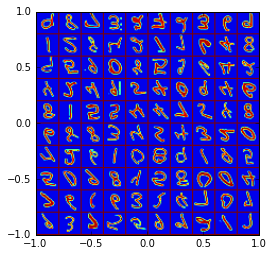

In [65]:
## Exercise 3 | Part 2: Neural Networks
input_layer_size = 400 # 20x20 Input Images of Digits
hidden_layer_size = 25 # 25 hidden units
num_labels = 10 # 10 labels, from 1 to 10, 숫자 "0"은 label 10

## Part 1: Loading and Visualizing Data

# Load Training Data

mat_contents = sio.loadmat('ex3data1.mat')

X = mat_contents['X']
y = mat_contents['y']

y = np.array(y[0:,0])

m = X.shape[0]

# 임의로 100개의 데이터를 선택해서 표시한다.
rand_indices = np.arange(m)
random.shuffle(rand_indices)

sel = X[rand_indices[0:100,], :] # 100x400

displayData(sel)

In [66]:
## Part 2: Loading Parameters

mat_contents = sio.loadmat('ex3weights.mat')

Theta1 = mat_contents['Theta1']
Theta2 = mat_contents['Theta2']

## Part 3. Implement Predict

neural network를 트레이닝하고 난 후, label을 예측하기 위해 그것을 사용할 수 있다. "predict" 함수를 구현해서 neural network를 이용해 트레이닝 셋의 라벨을 예측해본다. 이것으로 트레이닝 셋에 대한 정확도를 계산할 수 있다.


In [67]:
def predict(Theta1, Theta2, X):
    """
    학습된 neural network에 주어진 입력의 label을 예측한다.
    p 는 주어진 neural network의 trained weights (Theta1, Theta2)로 행렬 X의
    예측된 label이 된다.
    """

    m = X.shape[0] # m = 5000
    
    # 다음 변수를 올바르게 반환해야 한다.
    p = np.zeros(m)
    
    # p 는 1에서 num_labels 사이의 label이 된다.
    
    # 1컬럼을 X 행렬에 추가한다.
    X = np.hstack((np.ones((m, 1)), X))
    z = Theta1.dot(X.T)
    a2 = sigmoid(z) # 25x5000

    a2 = a2.T # 5000x25
    
    # 1컬럼을 a2 행렬에 추가한다.
    a2 = hstack((np.ones((a2.shape[0], 1)), a2))
    z = Theta2.dot(a2.T)
    a3 = sigmoid(z) # 10x5000
    

    # argmax(): 최대값의 인덱스 정보를 반환한다.
    # y = 10 10 (10 => 숫자 "0"이라는 의미)
    # p = 9 9 
    p = np.argmax(a3, axis=0)
    p = p + 1

    return p
    
    
pred = predict(Theta1, Theta2, X)

# In Octave: Training Set Accuracy: 97.520000
print('Training Set Accuracy: %s \n' % (mean(double(pred == y)) * 100))

Training Set Accuracy: 97.52 



network의 출력에 대한 아이디어를 제공하기 위해서, 한번에 하나의 example을 실행해보고 무엇을 예측했는지 볼 수 있다.

Diplaying Example Image
Neural Network Prediction: [5] (digit 5)
Diplaying Example Image
Neural Network Prediction: [10] (digit 10)
Diplaying Example Image
Neural Network Prediction: [3] (digit 3)
Diplaying Example Image
Neural Network Prediction: [3] (digit 3)
Diplaying Example Image
Neural Network Prediction: [4] (digit 4)
Diplaying Example Image
Neural Network Prediction: [1] (digit 1)
Diplaying Example Image
Neural Network Prediction: [1] (digit 1)
Diplaying Example Image
Neural Network Prediction: [5] (digit 5)
Diplaying Example Image
Neural Network Prediction: [3] (digit 3)
Diplaying Example Image
Neural Network Prediction: [5] (digit 5)


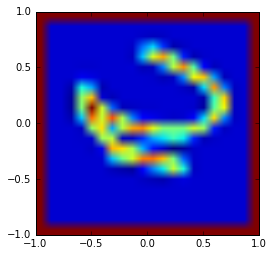

In [68]:
rand_indices = np.arange(m)
random.shuffle(rand_indices)

# 임의로 10개만 선택해서 보여준다.
for i in np.arange(10):
    # ******************************************************************
    # XXX: displayData(), predict() 함수는 X를 2차원 벡터로 입력받는다.
    # ******************************************************************
    idx = rand_indices[i]
    A = np.array([X[idx, :]])
    print('Diplaying Example Image')
    displayData(A)
    
    pred = predict(Theta1, Theta2, A)
    print('Neural Network Prediction: %s (digit %s)' % (pred, y[idx]))